Cargamos la información provista para el TP

In [1]:
load("TP4.Rdata", verbose = TRUE)

Loading objects:
  esp_train
  RRL
  esp_test
  diag_test
  .Random.seed
  diag_train


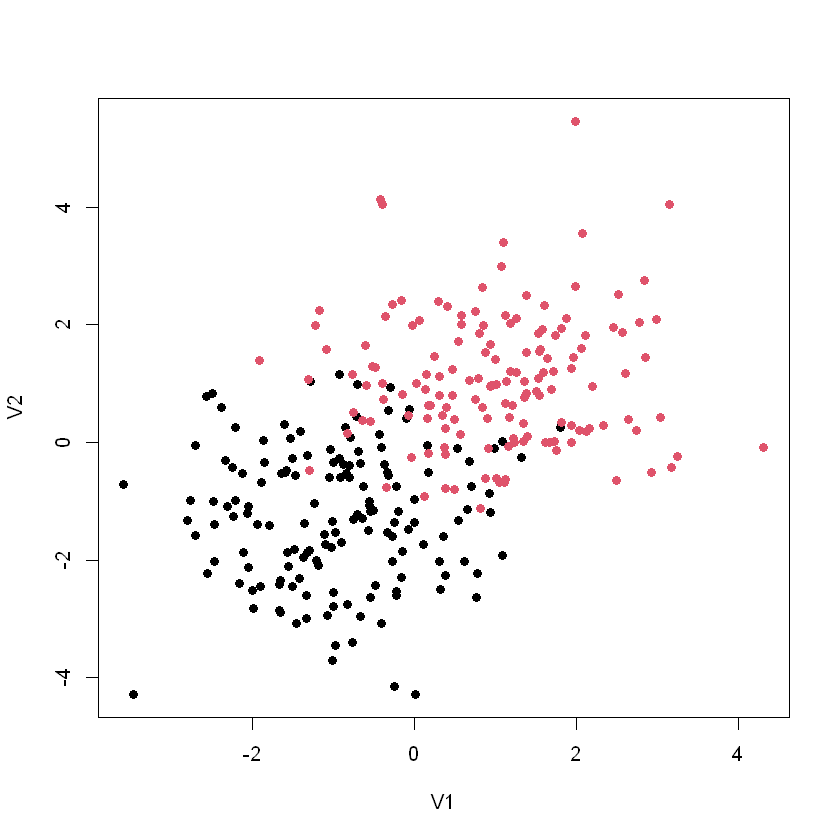

In [2]:
plot(diag_train[,-3], col = diag_train[,3], pch = 20, cex = 1.5)

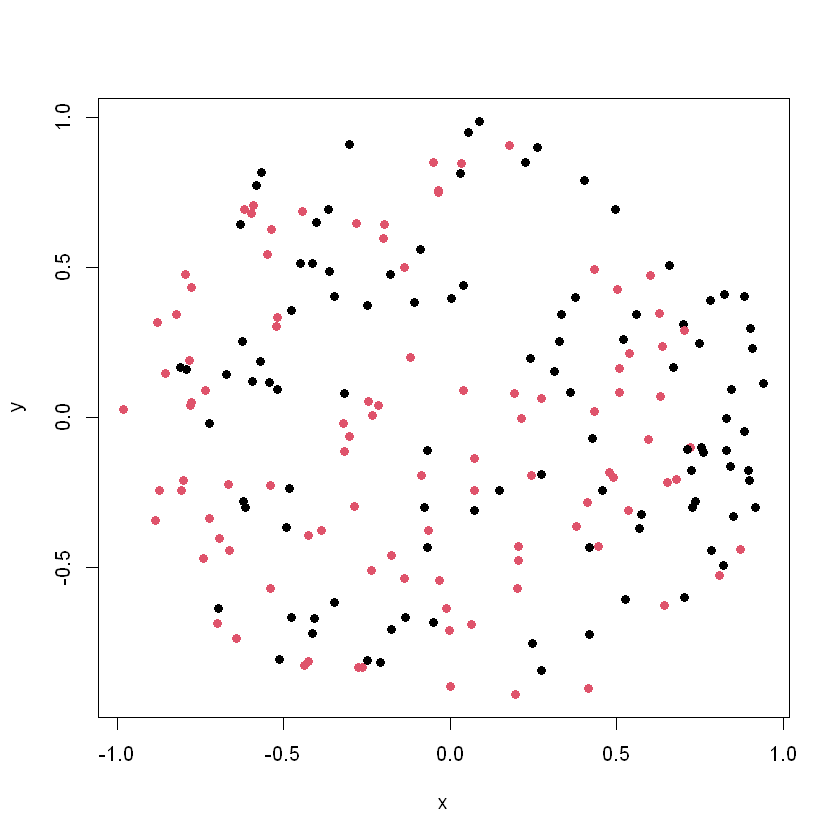

In [3]:
plot(esp_train[,-3], col=esp_train[,3], pch=20, cex=1.5)

In [4]:
install.packages("robustbase")

: 

: 

In [ ]:
install.packages("caret")

In [2]:
# install.packages("adabag")
library("adabag")

Warning message:
"package 'adabag' was built under R version 4.2.2"
Loading required package: rpart

Loading required package: caret

Warning message:
"package 'caret' was built under R version 4.2.2"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.2.2"
Loading required package: lattice

Loading required package: foreach

Warning message:
"package 'foreach' was built under R version 4.2.2"
Loading required package: doParallel

Warning message:
"package 'doParallel' was built under R version 4.2.2"
Loading required package: iterators

Warning message:
"package 'iterators' was built under R version 4.2.2"
Loading required package: parallel



In [5]:
data("iris")
train <- c(sample(1:50, 25), sample(51:100, 25), sample(101:150, 25))
iris.adaboost <- boosting(Species ~ ., data = iris[train, ], mfinal = 10, coef="Freund", control = rpart.control(maxdepth =
3))


Hacemos 20 arboles, que varian en profundidad de 1 a 20. Cada ensemble tiene 200 arboles.

In [20]:
pred_esp_test <- double(20)
pred_diag_test <- double(20)

for( i in 1:20){
  esp.adaboost <- boosting(class ~ ., data = esp_train, mfinal = 200, coef="Freund", control = rpart.control(maxdepth =
i))
  pred_esp_test[i] <- predict(esp.adaboost, newdata = esp_test, type = "class")$error
  
  diag.adaboost <- boosting(class ~ ., data = diag_train, mfinal = 200, coef="Freund", control = rpart.control(maxdepth =
i))
  pred_diag_test[i] <- predict(diag.adaboost, newdata = diag_test, type = "class")$error
}

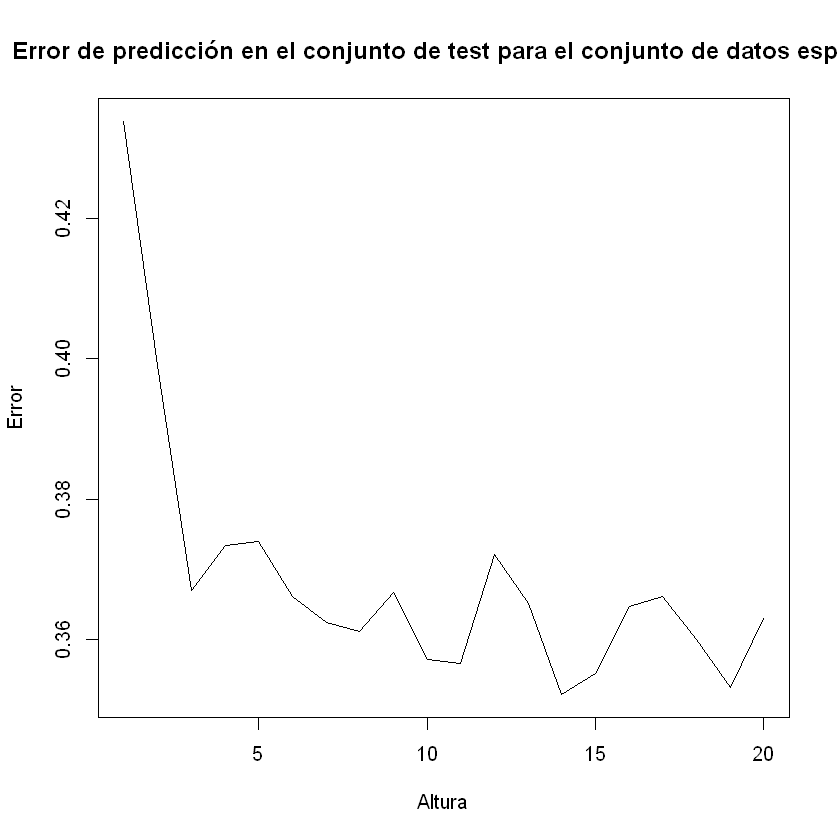

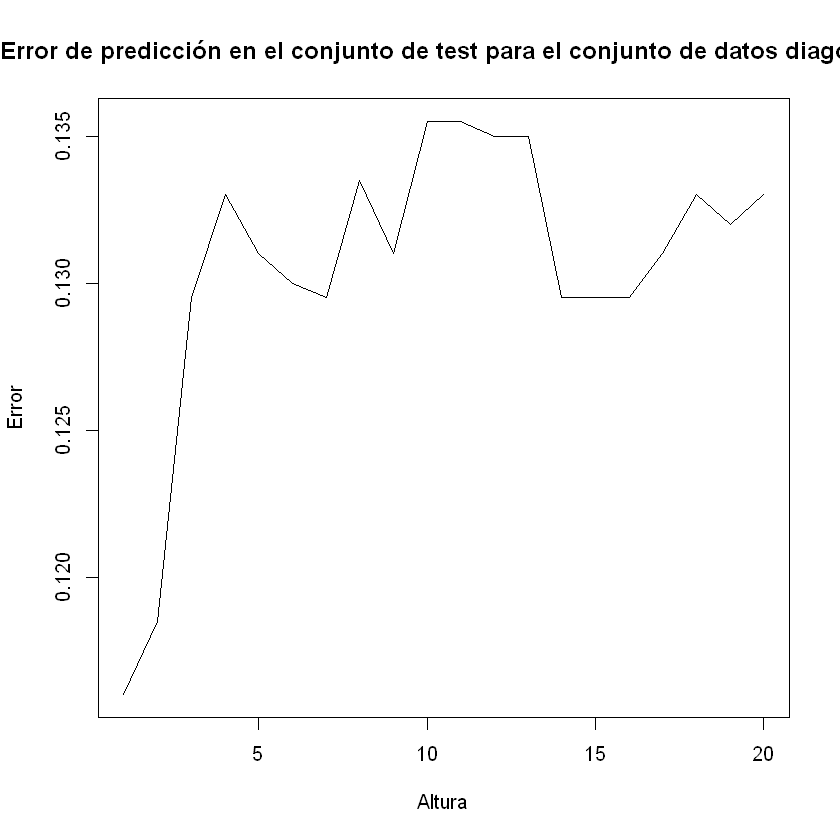

In [23]:
plot(1:20,pred_esp_test[1:20], type = "l", xlab="Altura", ylab="Error", main="Error de predicción en el conjunto de test para el conjunto de datos espiral")
plot(1:20,pred_diag_test[1:20], type = "l", xlab="Altura", ylab="Error", main="Error de predicción en el conjunto de test para el conjunto de datos diagonal")

Podemos ver que, en el caso del dataset espiral, el error disminuye considerablemente para árboles de profundidad 5. Luego existen altibajos, pero se mantienen dentro de un margen estable y parece que tienden a bajar si aumentáramos la profundidad.

Me sorprendió el caso del dataset diagonal, donde el error aumenta a partir de los 5 árboles. Creo que esto se debe a que el dataset es muy simple y no tiene mucho sentido hacer árboles de profundidad mayor a 5.

Vamos a analizar ahora el dataset RRL

In [24]:
summary(RRL)

   Amplitude       AndersonDarling  Autocor_length    Beyond1Std      
 Min.   :0.01550   Min.   :0.1237   Min.   :1.000   Min.   :0.007143  
 1st Qu.:0.09469   1st Qu.:0.9474   1st Qu.:1.000   1st Qu.:0.228361  
 Median :0.14950   Median :1.0000   Median :1.000   Median :0.271930  
 Mean   :0.15444   Mean   :0.9109   Mean   :1.252   Mean   :0.258909  
 3rd Qu.:0.19300   3rd Qu.:1.0000   3rd Qu.:1.000   3rd Qu.:0.307295  
 Max.   :1.57950   Max.   :1.0000   Max.   :7.000   Max.   :0.638060  
    CAR_mean          CAR_sigma            CAR_tau             Con           
 Min.   :     0.0   Min.   :-57.33259   Min.   :      0   Min.   :0.0000000  
 1st Qu.:    24.0   1st Qu.: -0.16407   1st Qu.:      0   1st Qu.:0.0000000  
 Median :    27.5   Median :  0.00000   Median :      1   Median :0.0000000  
 Mean   :  9695.5   Mean   :  0.45900   Mean   :   7144   Mean   :0.0004529  
 3rd Qu.:   149.2   3rd Qu.:  0.00459   3rd Qu.:      1   3rd Qu.:0.0000000  
 Max.   :773430.0   Max.   :208.874

La variable a predecir es Tipo. Vamos a usar Random Forest y variar la cantidad de features evaluadas en cada caso.

In [3]:
# install.packages("randomForest")
library("randomForest")

Warning message:
"package 'randomForest' was built under R version 4.2.2"
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin




In [19]:
cant.vars <- c(69, 34, 17, 8, 4, 2, 1) #Cantidad de variables a usar en cada paso, dada en el enunciado
errors_rf <- double(7) #Lista de errores

for (k in 1:7){
    error_k <- double(50) #Vector de errores para el k actual
    for(i in 1:5){
        rf <- randomForest(Tipo ~ . , data = RRL, mtry = cant.vars[k], ntree = 1000) #1000 es el número mágico de árboles
        miss <- rf$confusion[1,2] + rf$confusion[2,1] #Cantidad de errores
        error_k[i] <- miss/7060 #Error de predicción en el intento i
    }
    errors_rf[k] <- mean(error_k) #Guardo los errores para el k actual
}

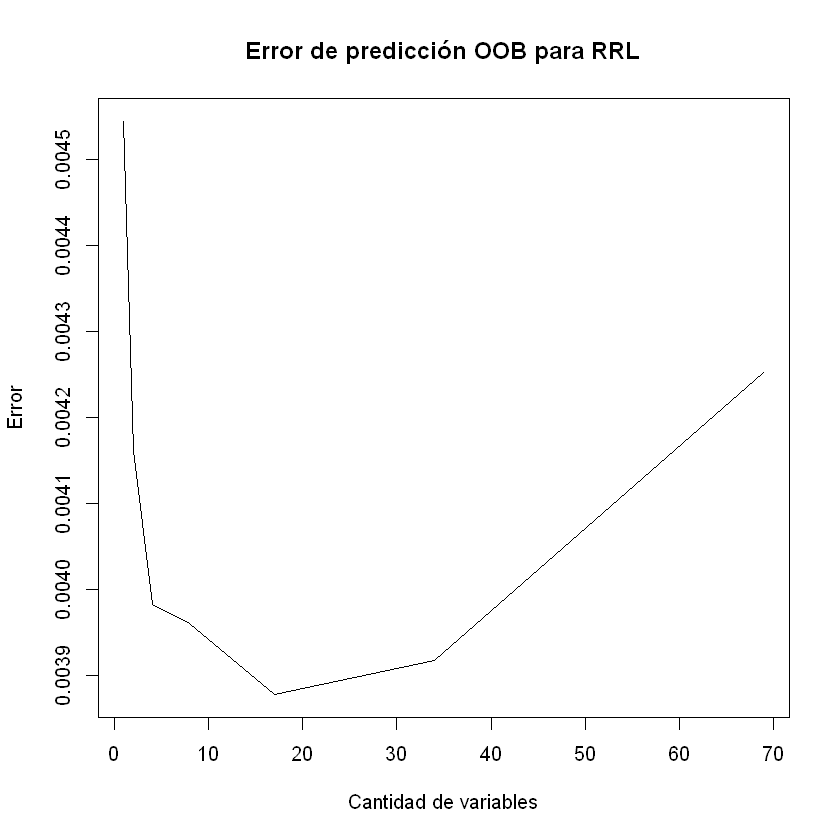

In [20]:
plot(cant.vars,errors_rf, type = "l", xlab="Cantidad de variables", ylab="Error", main="Error de predicción OOB para RRL")

Partimos de la base que el error ya es pequeño (menos del 5%). Se puede observar que el error disminuye rápidamente hasta las 17 variables utilizadas, y luego comienza a aumentar. Según las optimizaciones vistas en teoría, el valor default de mtry debería ser 8 o 9 (sqrt(69) = 8.31). Al aumentar la cantidad de variables, estamos recuperando bagging y aumentando el error, lo cual concuerda con lo visto que Random Forest es una mejora sobre bagging.

Vemos que en 8 variables el error ya es bastante bajo. Por lo tanto, podemos concluir que el valor por defecto de mtry es adecuado para este dataset.

In [4]:
library("e1071")

Warning message:
"package 'e1071' was built under R version 4.2.2"


Analicemos ahora el dataset Lampone. Vamos a empezar a estimar parámetros para usar Boosting, Random Forest y SVM.

In [5]:
load("lampone.Rdata", verbose = TRUE)

Loading objects:
  lampone


Primero alteramos el dataset para que los datos no queden muy parecidos

In [6]:
lamponeSampled <- lampone[sample(nrow(lampone)),]
dim(lamponeSampled)

[1]  49 144

Como tengo muy pocos datos (49) voy a hacer 5-Fold Cross-Validation (como en el TP 1). Voy a repetir los procedimientos de los apartados anteriores para Boosting y Random Forest, y buscar kernels adecuados con SVM.



In [21]:
#Buscamos un conjunto de train
trainIndex <- sample(1:nrow(lamponeSampled), 0.8 * nrow(lamponeSampled))
trainData <- lamponeSampled[trainIndex, ]
testData <- lamponeSampled[-trainIndex, ]

# Para guardar los errores
errors_lampone_boosting <- double(20)

for( i in 1:10){
    lampone.adaboost <- boosting(N_tipo ~ ., data = trainData, mfinal = 200, coef="Freund", control = rpart.control(maxdepth = i))
    errors_lampone_boosting[i] <- predict(lampone.adaboost, newdata = testData, type = "class")$error
}

1

2

3

4

5

6

7

8

9

10



In [22]:
for( i in 11:20){
    lampone.adaboost <- boosting(N_tipo ~ ., data = trainData, mfinal = 200, coef="Freund", control = rpart.control(maxdepth = i))
    errors_lampone_boosting[i] <- predict(lampone.adaboost, newdata = testData, type = "class")$error
}

11

12

13

14

15

16

17

18

19

20



Tuve que hacer lo anterior en dos partes porque por alguna razón no paraba de explotar. No pude aplicar 5-Fold Cross-Validation porque constantemente tiraba este error: 
Error in cbind(yval2, yprob, nodeprob): number of rows of matrices must match (see arg 2)
Traceback:

1. boosting(N_tipo ~ ., data = trainData, mfinal = 200, coef = "Freund", 
 .     control = rpart.control(maxdepth = i))
2. rpart(formula, data = data[boostrap, -1], control = control)
3. cbind(yval2, yprob, nodeprob)

Lo hacía de forma aleatoria y realmente no entiendo por qué.



 [1] 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
[20] 0.1


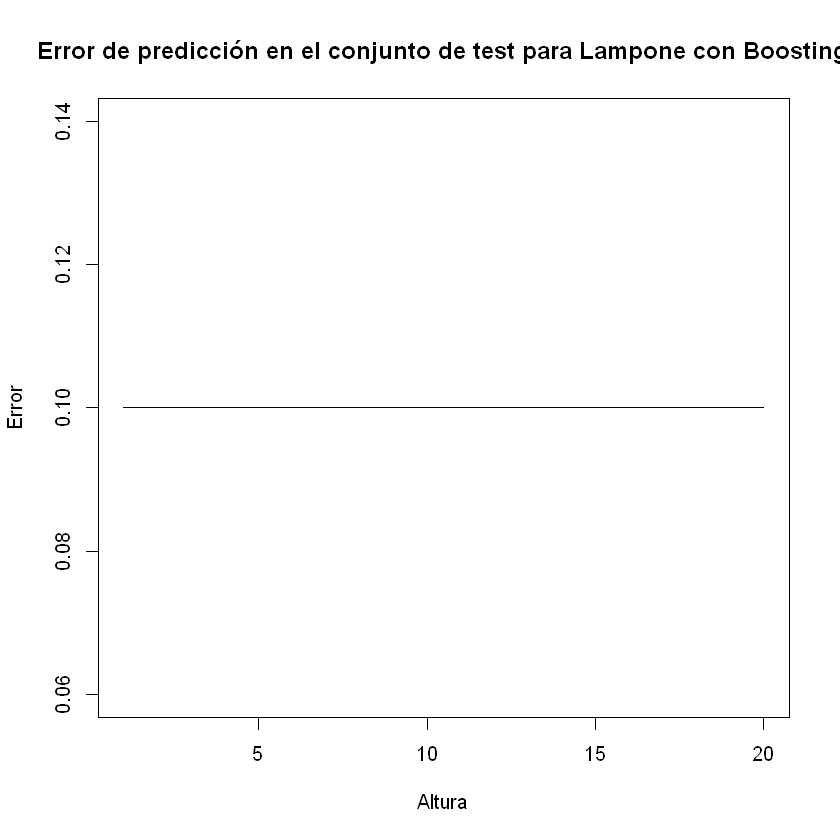

In [26]:
print(errors_lampone_boosting)
plot(1:20,errors_lampone_boosting[1:20], type = "l", xlab="Altura", ylab="Error", main="Error de predicción en el conjunto de test para Lampone con Boosting")

Parece que cualquier altura es buena para boosting, dando siempre error de 0.1. Vamos a quedarnos con 10 de profundidad. Para corroborarlo, vamos a hacer 5-Fold Cross-Validation (esperemos que esta vez no explote todo). Recordemos lo que hicimos en el TP 1

In [29]:
#Creamos un arreglo de indices que representa los folds
foldsIndex <- cut(seq(1,nrow(lamponeSampled)),breaks=5,labels=FALSE)

# Para guardar los errores
errors <- c()

#5-fold cross-validation
for(i in 1:5){
    #Buscamos los indices del fold correspondiente 
    testIndexes <- which(foldsIndex==i,arr.ind=TRUE)
    # Generamos los conjuntos de test y train
    testData <- lamponeSampled[testIndexes, ]
    trainData <- lamponeSampled[-testIndexes, ]
    #Entrenamos
    lampone.adaboost <- boosting(N_tipo ~ ., data = trainData, mfinal = 200, coef="Freund", control = rpart.control(maxdepth = 10))
    errors[i] <- predict(lampone.adaboost, newdata = testData, type = "class")$error
}
print("Errores en cada iteración:")
print(errors)
print(paste("Promedio de los errores: ", mean(errors)))

[1] "Errores en cada iteración:"
[1] 0.1 0.1 0.0 0.0 0.0
[1] "Promedio de los errores:  0.04"


El error parece ser bastante bajo. Me hubiera gustado poder hacer Cross-Validation, pero no pude. Voy a quedarme con este resultado.

Ahora, para estimar los parámetros de Random Forest, vamos a seguir usando 1000 árboles pero veamos cuántas variables son las adecuadas. Acá no hago folds porque puedo usar el error OOB.

In [9]:
lamponeSin144 <- lampone[,-144] #Tengo que sacar la 144 porque Random Forest no puede procesar más de 53 niveles
cant.vars <- c() #Cantidad de variables a usar en cada paso, dada en el enunciado
v <- 142 #Lampone tiene 144 variables
while(v >= 1){
    cant.vars <- c(cant.vars, v)
    v <- floor(v/2)
}
cant.vars
errors_rf <- double(length(cant.vars)) #Lista de errores

for (k in 1:length(cant.vars)){
    error_k <- double(5) #Vector de errores para el k actual
    for(i in 1:5){
        rf <- randomForest(N_tipo ~ . , data = lamponeSin144, mtry = cant.vars[k], ntree = 1000) #1000 es el número mágico de árboles
        miss <- rf$confusion[1,2] + rf$confusion[2,1] #Cantidad de errores
        error_k[i] <- miss/49 #Error de predicción en el intento i
    }
    errors_rf[k] <- mean(error_k) #Guardo los errores para el k actual
}

[1] 142  71  35  17   8   4   2   1

[1] 0.16326531 0.12244898 0.08163265 0.08571429 0.10612245 0.10204082 0.10612245
[8] 0.12653061


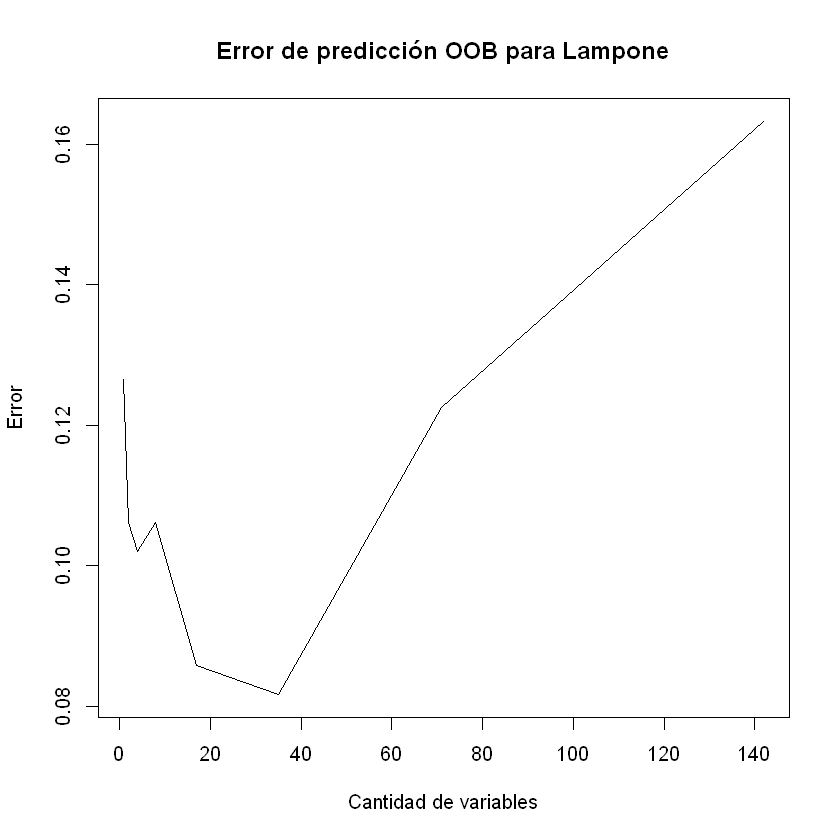

In [11]:
print(errors_rf)
plot(cant.vars,errors_rf, type = "l", xlab="Cantidad de variables", ylab="Error", main="Error de predicción OOB para Lampone")

Muy similar al caso de RRL, el error disminuye hasta las 17 variables utilizadas, hasta alcanzar su mínimo en las 35. Acá tenemos que sqrt(142) = 11.89, por lo que el valor default de mtry vuelve a resultar adecuado. Me parece curioso destacar que en ambos casos, quedarse con un cuarto de las variables resultó mejor.


Para SVM con kernel polinomial, vamos a tener que hacer kfold y hacer variar el grado del polinomio.


In [31]:
#Creamos un arreglo de indices que representa los folds
foldsIndex <- cut(seq(1,nrow(lamponeSampled)),breaks=5,labels=FALSE)

# Para guardar los errores
errors_svm_poly <- c(10)

#5-fold cross-validation
for(k in 1:10){
    errors <- double(5)
    for(i in 1:5){
        #Buscamos los indices del fold correspondiente 
        testIndexes <- which(foldsIndex==i,arr.ind=TRUE)
        # Generamos los conjuntos de test y train
        testData <- lamponeSampled[testIndexes, ]
        trainData <- lamponeSampled[-testIndexes, ]
        #Entrenamos usando un kernel polinomial
        suppressWarnings(svmModel <- svm(N_tipo ~ ., data = trainData, scale = TRUE, type = 'C-classification', kernel = "polynomial", degree = k, cost = 1))
        svmPredict <- predict(svmModel, newdata = testData)
        #Calculate error
        errors[i] <- sum(svmPredict != testData$N_tipo)/length(svmPredict)
    }
    errors_svm_poly[k] <- mean(errors)
}
print("Errores en cada iteración:")
print(errors_svm_poly)

[1] "Errores en cada iteración:"
 [1] 0.2444444 0.1622222 0.1422222 0.1422222 0.1422222 0.2044444 0.2044444
 [8] 0.2044444 0.2044444 0.2044444


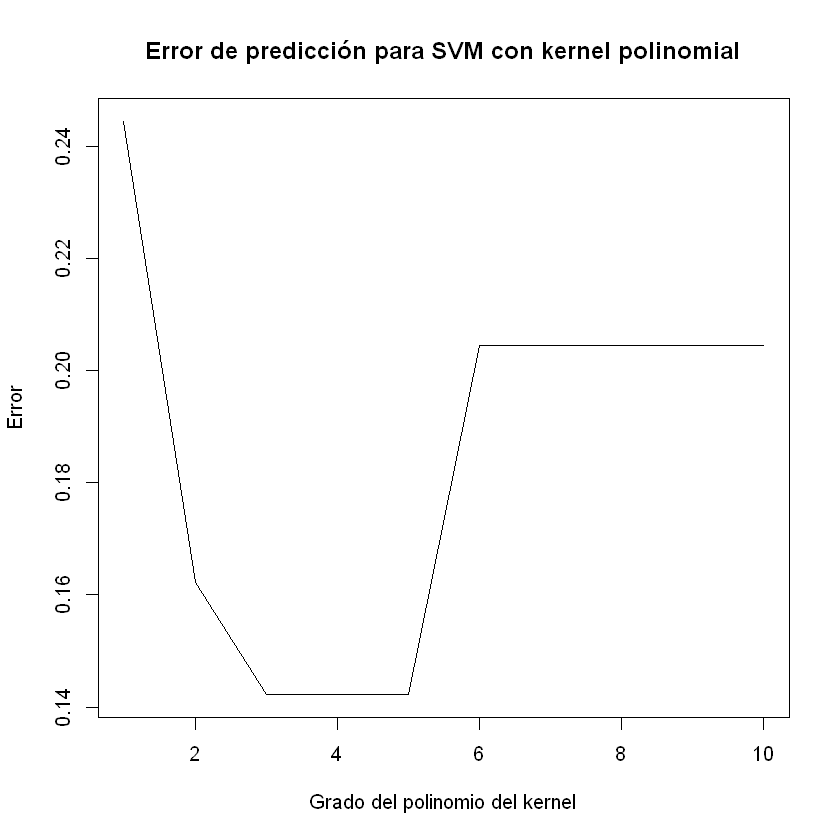

In [32]:
plot(1:10,errors_svm_poly, type = "l", xlab="Grado del polinomio del kernel", ylab="Error", main="Error de predicción para SVM con kernel polinomial")

El polinomio de grado 3 parece ser el correcto para el kernel



Para SVM con kernel radial, vamos a repetir lo anterior y hacer variar el gamma.


In [41]:
#Creamos un arreglo de indices que representa los folds
foldsIndex <- cut(seq(1,nrow(lamponeSampled)),breaks=5,labels=FALSE)

# Para guardar los errores
errors_svm_rbf <- c(10)

#5-fold cross-validation
for(k in 1:10){
    errors <- double(5)
    g <- 0.00001 * k
    for(i in 1:5){
        #Buscamos los indices del fold correspondiente 
        testIndexes <- which(foldsIndex==i,arr.ind=TRUE)
        # Generamos los conjuntos de test y train
        testData <- lamponeSampled[testIndexes, ]
        trainData <- lamponeSampled[-testIndexes, ]
        #Entrenamos esta vez usando un kernel RBF
        suppressWarnings(svmModel <- svm(N_tipo ~ ., data = trainData, scale = TRUE, type = 'C-classification', kernel = "radial", gamma = g, cost = 1))
        svmPredict <- predict(svmModel, newdata = testData)
        #Calculate error
        errors[i] <- sum(svmPredict != testData$N_tipo)/length(svmPredict)
    }
    errors_svm_rbf[k] <- mean(errors)
}
print("Errores en cada iteración:")
print(errors_svm_rbf)

[1] "Errores en cada iteración:"
 [1] 0.5488889 0.5066667 0.4222222 0.3600000 0.3622222 0.3622222 0.3422222
 [8] 0.3422222 0.3622222 0.3622222


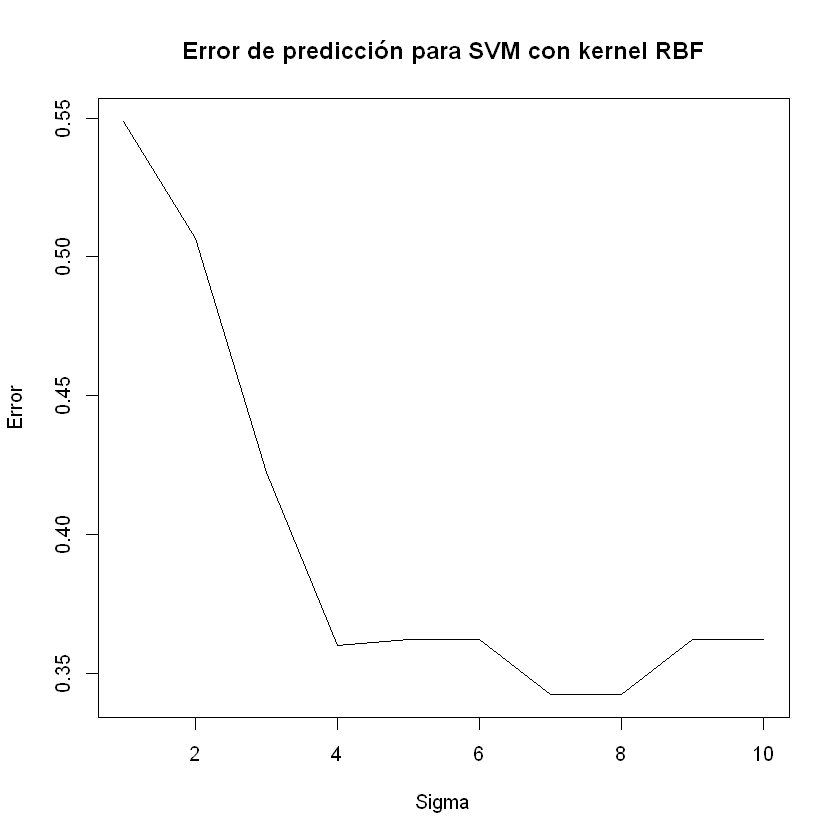

In [42]:
plot(1:10,errors_svm_rbf, type = "l", xlab="Sigma", ylab="Error", main="Error de predicción para SVM con kernel RBF")

Después de mucho probar, me di cuenta que con gammas pequeños funciona mejor. Gamma de 0.00007 me dió los mejores resultados.

El proceso me resultó bastante tedioso, pero logré estimar todos los parámetros de una forma que creo que fue óptima. No consideré variar el parámetro de costo del error, sino que lo dejé en el valor por defecto (C = 1)